# class 11: From Trees to Forests

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
#import matplotlib as mpl
import matplotlib.pyplot as plt

#from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor

from sklearn import tree
from graphviz import Source
import graphviz
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.externals.six import StringIO  


from sklearn.inspection import permutation_importance

ModuleNotFoundError: No module named 'graphviz'

## Classification tree, Titanic

Let us build a classification tree on the Titanic data using `Survived` as the outcome and `Sex, Pclass, Age, PassengerId` as explanatory variables

In [15]:
df = pd.read_csv('../data/TitanicTrain.csv') # Load the data
one_hot_data = pd.get_dummies(df[["Sex", "Pclass", "Age", "PassengerId","Survived"]])
one_hot_data.head()


,Pclass,Age,PassengerId,Survived,Sex_female,Sex_male
0,3,22.0,1,0,0,1
1,1,38.0,2,1,1,0
2,3,26.0,3,1,1,0
3,1,35.0,4,1,1,0
4,3,35.0,5,0,0,1


In [16]:
train=one_hot_data[["Sex_male", "Pclass", "Age", "PassengerId","Survived"]].dropna()
X_train = train[["Sex_male", "Pclass", "Age", "PassengerId"]]
Y_train = train["Survived"]

### Shallow tree of depth 2

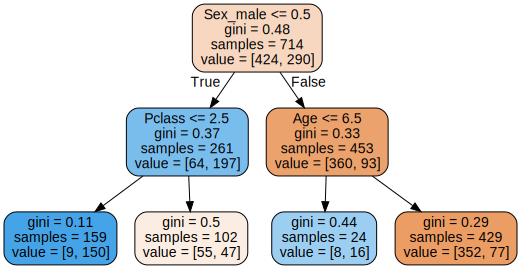

In [18]:
plt.rcParams["figure.figsize"]=3,3

clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X_train, Y_train)

dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X_train.columns, 
                                precision = 2,
                    filled=True, rounded=True)  
graph = graphviz.Source(dot_data)  
graph 

### Variable Importance



In [ ]:
#MDI
MDI_importances = clf.feature_importances_
indices = np.argsort(MDI_importances)
features = X_train.columns

In [29]:
#permutation importance:
MDA_importances = permutation_importance(clf, X_train, Y_train, n_repeats=5,random_state=42, n_jobs=2)
sorted_idx = MDA_importances.importances_mean.argsort()

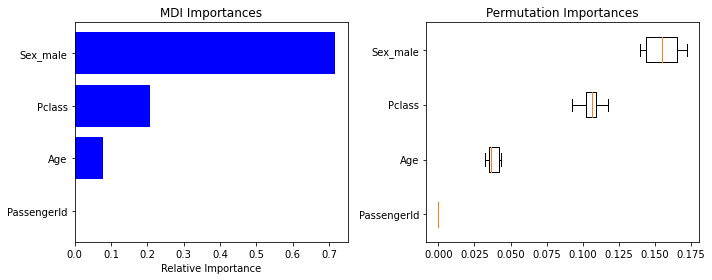

In [64]:
plt.rcParams["figure.figsize"]=10,4
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title('MDI Importances')
ax1.barh(range(len(indices)), MDI_importances[indices], color='b', align='center')
ax1.set_yticks( np.arange(4))
ax1.set_yticklabels(features[indices])
ax1.set(xlabel='Relative Importance')


ax2.boxplot(MDA_importances.importances[sorted_idx].T,
           vert=False, labels=features[sorted_idx])
tpmp=ax2.set_title("Permutation Importances")
fig.tight_layout()


#### Increasing tree depth 

Notice the finer and finer splits on Age and PassengerId

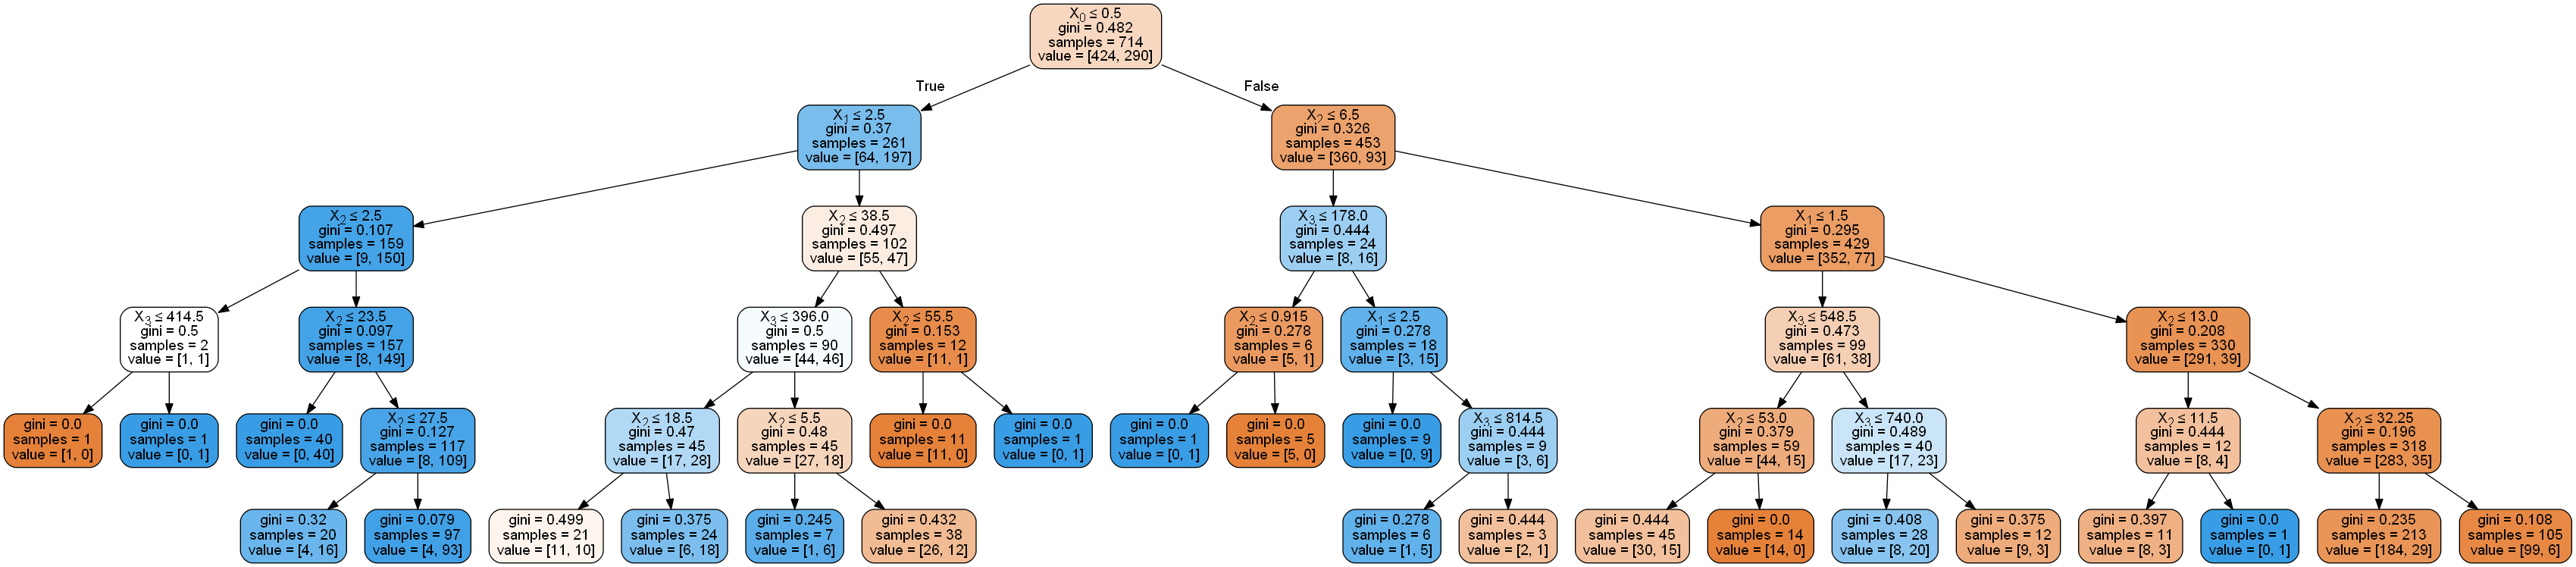

In [69]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, Y_train)

#Note that for larger trees the Image opetion might work beter:
if False:
    dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X_train.columns, 
                                precision = 1,
                    filled=True, rounded=True)  
    graph = graphviz.Source(dot_data)  
    graph
else:
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 

Image(graph.create_png())
#tmp=tree.plot_tree(clf) 

### Variable Importance

Notice that passenger ID and age are gaining MDI importance as the tree depth is increased!

In [70]:
#permutation importance:
MDA_importances = permutation_importance(clf, X_train, Y_train, n_repeats=5,random_state=42, n_jobs=2)
sorted_idx = MDA_importances.importances_mean.argsort()

#MDI
MDI_importances = clf.feature_importances_
indices = np.argsort(MDI_importances)
features = X_train.columns

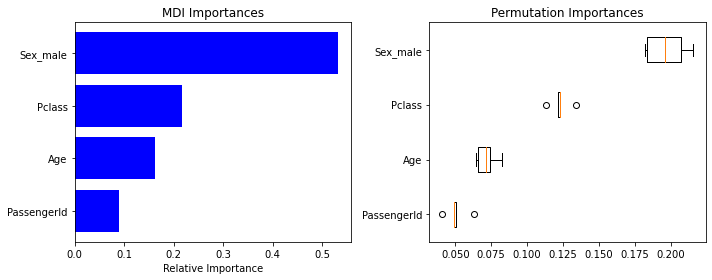

In [71]:
plt.rcParams["figure.figsize"]=10,4
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title('MDI Importances')
ax1.barh(range(len(indices)), MDI_importances[indices], color='b', align='center')
ax1.set_yticks( np.arange(4))
ax1.set_yticklabels(features[indices])
ax1.set(xlabel='Relative Importance')


ax2.boxplot(MDA_importances.importances[sorted_idx].T,
           vert=False, labels=features[sorted_idx])
tpmp=ax2.set_title("Permutation Importances")
fig.tight_layout()


## Ensembles of Estimators

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called *bagging*.
Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.
An ensemble of randomized decision trees is known as a *random forest*.

This type of bagging classification can be done manually using Scikit-Learn's ``BaggingClassifier`` meta-estimator, as shown here:

In [3]:
from sklearn.datasets import load_boston
import random
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

boston = load_boston()
random.seed(123)
shuffleRows = random.sample(range(506),506)
train = shuffleRows[0:300]
test = shuffleRows[300:450]
validate = shuffleRows[450:506]
X_train=boston.data[train]
y_train=boston.target[train]
X_test=boston.data[test]
y_test=boston.target[test]

In [4]:
tree_B1 = DecisionTreeRegressor(random_state=0)
tree_B1.fit(X_train, y_train)

singleTreePreds = tree_B1.predict(X_test)
np.sqrt(mean_squared_error(y_test, singleTreePreds))

5.637836464460458

### Bagging

In [8]:
baggedBoston = BaggingRegressor(base_estimator=tree_B1,n_estimators=200,oob_score=True)
#The folloing line of code does all of these steps:
# It fits 200 trees on 200 bootstrapped vrsions of your training data !!
baggedBoston.fit(X_train, y_train)
#The object now contains 200 trees 

# The predict function now computes 200 predistions for each data point and averages them !!
baggedPreds = baggedBoston.predict(X_test)

np.sqrt(mean_squared_error(y_test, baggedPreds))


True

In [10]:
baggedBoston.oob_score_ # this is ythe equivalent of your test set loss !

0.8515613117638946

### Random Forests

In [13]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(200, max_features=0.5, oob_score=True)
forest.fit(X_train, y_train)

forestPreds = forest.predict(X_test)
np.sqrt(mean_squared_error(y_test, forestPreds))

3.149270337448553

In [14]:
forest.oob_score_

0.8659229670006592

### Tasks

1. Find the best value for `mtry`
2. Plot the two kinds of variable importances